# Convolutional Neural Network (CNN) for Intel Image Classification Dataset
### Data

This code was inspired from this [kaggle code](https://www.kaggle.com/code/vyom71/image-classification-cnn-intel-data).

The dataset consists of approximately 25,000 images, each resized to 150x150 pixels, categorized into six classes:

| Class     | Label |
|-----------|-------|
| Buildings | 0     |
| Forest    | 1     |
| Glacier   | 2     |
| Mountain  | 3     |
| Sea       | 4     |
| Street    | 5     |

The dataset is structured into three parts:

- **Train**: ~14,000 images for training models.
- **Test**: ~3,000 images for testing.
- **Prediction**: ~7,000 images for model evaluation.


## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/nelsonloureiro/anaconda3/envs/py3-TF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/nelsonloureiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
train_dir = f"{path}/seg_train/seg_train"
test_dir = f"{path}/seg_test/seg_test"

In [4]:
classes = os.listdir(train_dir)
print("Classes: ",classes)

Classes:  ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [5]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")  
total = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
print(f"Total images are {total}")

forest: 2271 images
buildings: 2191 images
glacier: 2404 images
street: 2382 images
mountain: 2512 images
sea: 2274 images
Total images are 14034


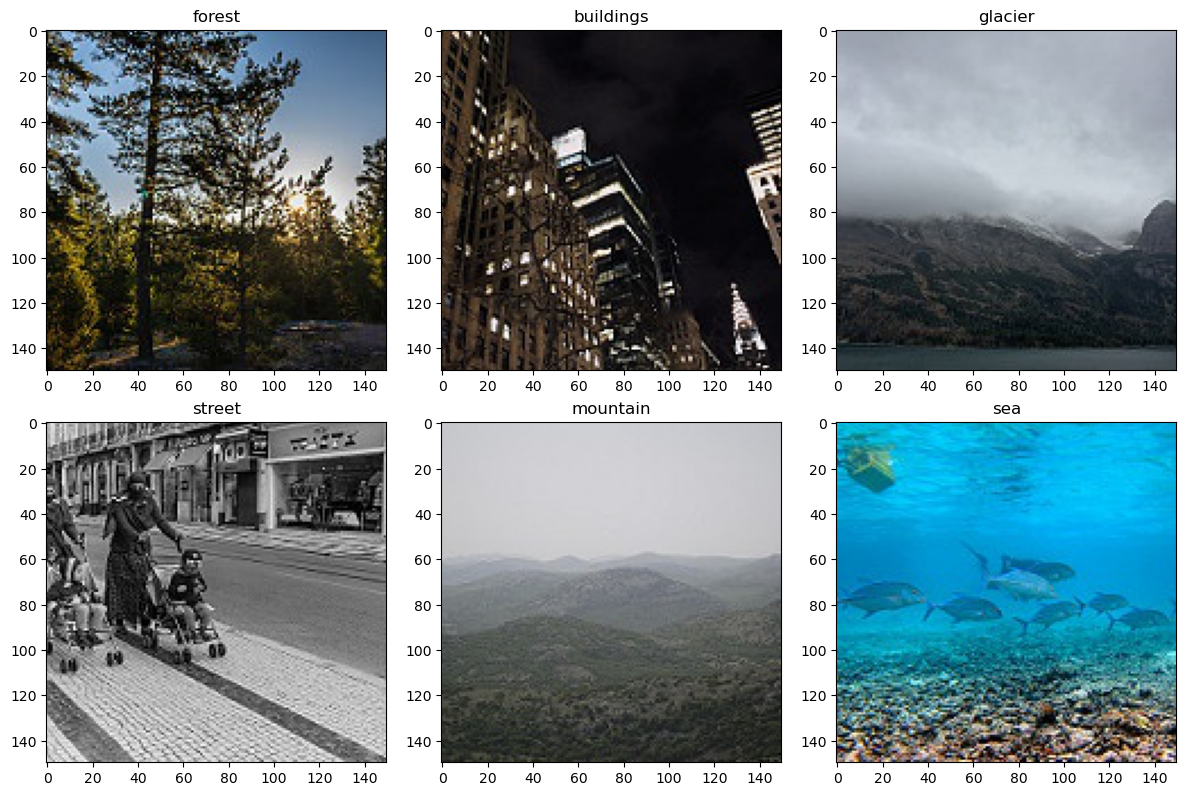

In [6]:
plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
    cls_path = os.path.join(train_dir,cls)
    img_path = os.path.join(cls_path,os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

#### I created 3 pipelines for Training, Validation and Testing data so Flow From Directory take cares about everything from data gethering from directory apply data augmentation (on-the-fly) divide into training and validation classes with given batch_size and target_size

In [8]:
img_size = (150,150)
batch_size = 32

print('Training subset:')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

print('\nValidation subset:')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

print('\nTest subset:')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Training subset:
Found 11230 images belonging to 6 classes.

Validation subset:
Found 2804 images belonging to 6 classes.

Test subset:
Found 3000 images belonging to 6 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    shuffle = False,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3000 images belonging to 6 classes.


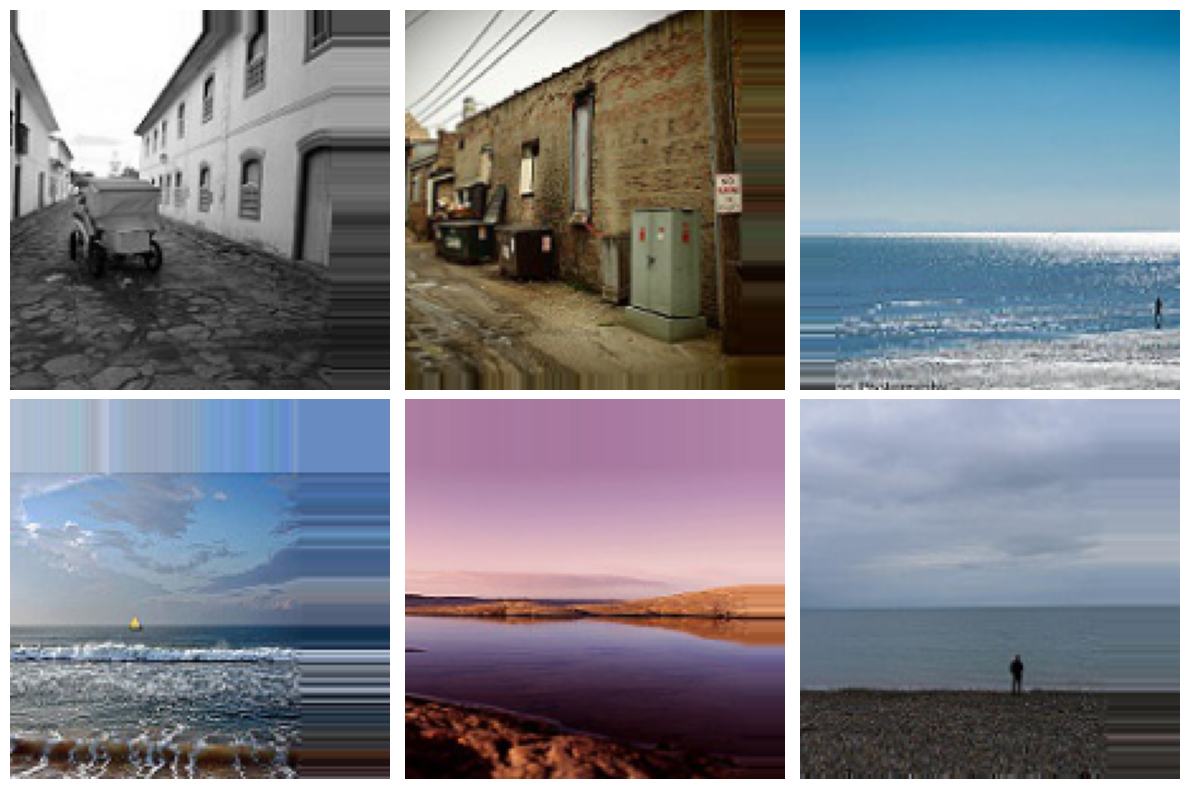

In [10]:
# Displaying a single batch of images
x_batch , y_batch = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
x_batch.shape, y_batch.shape

((32, 150, 150, 3), (32, 6))

## CNN Model

In [12]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np

%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix,classification_report
import io
import itertools

## Defining hyperparameters

In [25]:
input_size = (150,150,3)
output_size = 6

HP_HIDDEN_LAYER_SIZE = hp.HParam('hidden_layer_size', hp.Discrete([25, 50, 100, 200]))
#HP_HIDDEN_LAYER_SIZE = hp.HParam('hidden_layer_size', hp.Discrete([25]))
HP_ACTIVATION = hp.HParam('activation_function', hp.Discrete(['relu', 'sigmoid']))
#HP_ACTIVATION = hp.HParam('activation_function', hp.Discrete(['sigmoid']))

METRIC_ACCURACY = 'accuracy'
METRIC_PRECISION = 'precision'
METRIC_RECALL = 'recall'
METRIC_F1 = 'f1_score'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_HIDDEN_LAYER_SIZE, HP_ACTIVATION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
             hp.Metric(METRIC_PRECISION, display_name='Precision'),
             hp.Metric(METRIC_RECALL, display_name='Recall'),
             hp.Metric(METRIC_F1, display_name='F1 Score')]
  )

## Creating functions for training our model and for logging purposes

#### Confusion matrix

In [14]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [15]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [16]:
def log_confusion_matrix(model, file_writer_cm):
    predictions = model.predict(test_generator)
    labels = {value: key for key, value in test_generator.class_indices.items()}

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    # for i in range(10): 
    #     print(f"True Class: {true_classes[i]} | Predicted Class: {predicted_classes[i]}")

    cm = confusion_matrix(true_classes, predicted_classes)
    
    figure = plot_confusion_matrix(cm, class_names=labels.values())
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=1)  

    # c.f.: https://www.statology.org/sklearn-classification-report/
    return classification_report(true_classes, predicted_classes, target_names=labels.values(), output_dict=True, zero_division=1)
    

#### Model

In [26]:
def train_test_model(log_dir, hparams, file_writer_cm):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_size),  # input layer (1)
    
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    tf.keras.layers.Dense(hparams[HP_HIDDEN_LAYER_SIZE], activation=hparams[HP_ACTIVATION]), # 1st hidden layer
    tf.keras.layers.Dense(hparams[HP_HIDDEN_LAYER_SIZE], activation=hparams[HP_ACTIVATION]), # 2nd hidden layer
    tf.keras.layers.Dense(hparams[HP_HIDDEN_LAYER_SIZE], activation=hparams[HP_ACTIVATION]), # 3rd hidden layer
    
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer (5)
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  model.fit(
    train_generator,
    # in one epoch the generator will pass through all the training samples once. 
    steps_per_epoch = int( np.ceil(train_generator.samples / batch_size) ),
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback],
    validation_steps = int( np.ceil(validation_generator.samples / batch_size) ),
    verbose=2
  )
    
  report = log_confusion_matrix(model, file_writer_cm)

  # Overall metrics
  accuracy = report['accuracy']
  weighted_precision = report['weighted avg']['precision']
  weighted_recall = report['weighted avg']['recall']
  weighted_f1 = report['weighted avg']['f1-score']

  return accuracy, weighted_precision, weighted_recall, weighted_f1

## Training the model with the different hyperparameters

In [27]:
# Creating a function to log the resuls
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
        accuracy, precision, recall, f1_score = train_test_model(log_dir, hparams, file_writer_cm)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        tf.summary.scalar(METRIC_PRECISION, precision, step=1)
        tf.summary.scalar(METRIC_RECALL, recall, step=1)
        tf.summary.scalar(METRIC_F1, f1_score, step=1)

In [28]:
# Performing a grid search on the hyperparameters we need to test
session_num = 0

for hidden_layer_size in HP_HIDDEN_LAYER_SIZE.domain.values:
    for activation in HP_ACTIVATION.domain.values:
        hparams = {
            HP_ACTIVATION: activation,
            HP_HIDDEN_LAYER_SIZE: hidden_layer_size
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

--- Starting trial: run-0
{'activation_function': 'relu', 'hidden_layer_size': 25}
Epoch 1/30


2025-01-04 21:55:08.150825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 21:55:40.286874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 40s - loss: 1.9386 - accuracy: 0.3476 - val_loss: 1.6950 - val_accuracy: 0.3648 - 40s/epoch - 114ms/step
Epoch 2/30
351/351 - 41s - loss: 1.5405 - accuracy: 0.4131 - val_loss: 1.5195 - val_accuracy: 0.3905 - 41s/epoch - 116ms/step
Epoch 3/30
351/351 - 45s - loss: 1.4869 - accuracy: 0.4358 - val_loss: 1.3790 - val_accuracy: 0.4668 - 45s/epoch - 128ms/step
Epoch 4/30
351/351 - 47s - loss: 1.3755 - accuracy: 0.4678 - val_loss: 1.3536 - val_accuracy: 0.4757 - 47s/epoch - 134ms/step
Epoch 5/30
351/351 - 44s - loss: 1.3457 - accuracy: 0.4768 - val_loss: 1.2721 - val_accuracy: 0.5039 - 44s/epoch - 126ms/step
Epoch 6/30
351/351 - 42s - loss: 1.3441 - accuracy: 0.4775 - val_loss: 1.3135 - val_accuracy: 0.4882 - 42s/epoch - 119ms/step
Epoch 7/30
351/351 - 45s - loss: 1.3204 - accuracy: 0.4907 - val_loss: 1.3157 - val_accuracy: 0.4832 - 45s/epoch - 127ms/step
Epoch 8/30
351/351 - 41s - loss: 1.3171 - accuracy: 0.4931 - val_loss: 1.3354 - val_accuracy: 0.4626 - 41s/epoch - 118ms/step
Epo

2025-01-04 22:15:25.713227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 17ms/step
--- Starting trial: run-1
{'activation_function': 'sigmoid', 'hidden_layer_size': 25}
Epoch 1/30


2025-01-04 22:15:27.735481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 22:15:59.544033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 40s - loss: 1.7980 - accuracy: 0.1699 - val_loss: 1.7922 - val_accuracy: 0.1790 - 40s/epoch - 113ms/step
Epoch 2/30
351/351 - 40s - loss: 1.7933 - accuracy: 0.1696 - val_loss: 1.7919 - val_accuracy: 0.1790 - 40s/epoch - 113ms/step
Epoch 3/30
351/351 - 40s - loss: 1.7929 - accuracy: 0.1718 - val_loss: 1.7919 - val_accuracy: 0.1790 - 40s/epoch - 113ms/step
Epoch 4/30
351/351 - 41s - loss: 1.7930 - accuracy: 0.1736 - val_loss: 1.7917 - val_accuracy: 0.1790 - 41s/epoch - 117ms/step
Epoch 5/30
351/351 - 41s - loss: 1.7932 - accuracy: 0.1744 - val_loss: 1.7920 - val_accuracy: 0.1790 - 41s/epoch - 117ms/step
Epoch 6/30
351/351 - 41s - loss: 1.7934 - accuracy: 0.1771 - val_loss: 1.7915 - val_accuracy: 0.1790 - 41s/epoch - 116ms/step
Epoch 7/30
351/351 - 41s - loss: 1.7936 - accuracy: 0.1728 - val_loss: 1.7915 - val_accuracy: 0.1712 - 41s/epoch - 117ms/step
Epoch 8/30
351/351 - 41s - loss: 1.7925 - accuracy: 0.1776 - val_loss: 1.7920 - val_accuracy: 0.1790 - 41s/epoch - 116ms/step
Epo

2025-01-04 22:35:46.898925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 19ms/step
--- Starting trial: run-2
{'activation_function': 'relu', 'hidden_layer_size': 50}
Epoch 1/30


2025-01-04 22:35:49.217495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 22:36:22.444472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 41s - loss: 1.8227 - accuracy: 0.3744 - val_loss: 1.4206 - val_accuracy: 0.4476 - 41s/epoch - 118ms/step
Epoch 2/30
351/351 - 41s - loss: 1.4798 - accuracy: 0.4249 - val_loss: 1.5119 - val_accuracy: 0.4223 - 41s/epoch - 116ms/step
Epoch 3/30
351/351 - 42s - loss: 1.4238 - accuracy: 0.4451 - val_loss: 1.3094 - val_accuracy: 0.4882 - 42s/epoch - 119ms/step
Epoch 4/30
351/351 - 41s - loss: 1.3473 - accuracy: 0.4779 - val_loss: 1.3026 - val_accuracy: 0.4964 - 41s/epoch - 116ms/step
Epoch 5/30
351/351 - 41s - loss: 1.3589 - accuracy: 0.4681 - val_loss: 1.3209 - val_accuracy: 0.4840 - 41s/epoch - 116ms/step
Epoch 6/30
351/351 - 41s - loss: 1.3561 - accuracy: 0.4715 - val_loss: 1.4448 - val_accuracy: 0.4215 - 41s/epoch - 117ms/step
Epoch 7/30
351/351 - 41s - loss: 1.3530 - accuracy: 0.4663 - val_loss: 1.3009 - val_accuracy: 0.4850 - 41s/epoch - 118ms/step
Epoch 8/30
351/351 - 41s - loss: 1.3158 - accuracy: 0.4873 - val_loss: 1.2519 - val_accuracy: 0.5146 - 41s/epoch - 117ms/step
Epo

2025-01-04 22:56:20.100844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 19ms/step
--- Starting trial: run-3
{'activation_function': 'sigmoid', 'hidden_layer_size': 50}
Epoch 1/30


2025-01-04 22:56:22.330055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 22:56:54.840218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 41s - loss: 1.7976 - accuracy: 0.1791 - val_loss: 1.7912 - val_accuracy: 0.1790 - 41s/epoch - 116ms/step
Epoch 2/30
351/351 - 40s - loss: 1.7753 - accuracy: 0.2099 - val_loss: 1.7462 - val_accuracy: 0.2386 - 40s/epoch - 113ms/step
Epoch 3/30
351/351 - 40s - loss: 1.7399 - accuracy: 0.2396 - val_loss: 1.7187 - val_accuracy: 0.2789 - 40s/epoch - 114ms/step
Epoch 4/30
351/351 - 41s - loss: 1.6934 - accuracy: 0.2629 - val_loss: 1.7134 - val_accuracy: 0.2482 - 41s/epoch - 116ms/step
Epoch 5/30
351/351 - 40s - loss: 1.7015 - accuracy: 0.2432 - val_loss: 1.6464 - val_accuracy: 0.2842 - 40s/epoch - 114ms/step
Epoch 6/30
351/351 - 40s - loss: 1.6934 - accuracy: 0.2600 - val_loss: 1.6249 - val_accuracy: 0.2828 - 40s/epoch - 114ms/step
Epoch 7/30
351/351 - 41s - loss: 1.6347 - accuracy: 0.2888 - val_loss: 1.6239 - val_accuracy: 0.3021 - 41s/epoch - 115ms/step
Epoch 8/30
351/351 - 40s - loss: 1.6483 - accuracy: 0.2754 - val_loss: 1.6153 - val_accuracy: 0.2967 - 40s/epoch - 114ms/step
Epo

2025-01-04 23:16:31.184097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 22ms/step
--- Starting trial: run-4
{'activation_function': 'relu', 'hidden_layer_size': 100}
Epoch 1/30


2025-01-04 23:16:33.767915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 23:17:12.281862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 47s - loss: 1.8984 - accuracy: 0.3760 - val_loss: 1.5848 - val_accuracy: 0.4141 - 47s/epoch - 134ms/step
Epoch 2/30
351/351 - 44s - loss: 1.4700 - accuracy: 0.4368 - val_loss: 1.4340 - val_accuracy: 0.4608 - 44s/epoch - 124ms/step
Epoch 3/30
351/351 - 42s - loss: 1.3952 - accuracy: 0.4589 - val_loss: 1.3090 - val_accuracy: 0.4900 - 42s/epoch - 119ms/step
Epoch 4/30
351/351 - 40s - loss: 1.3436 - accuracy: 0.4768 - val_loss: 1.3512 - val_accuracy: 0.4668 - 40s/epoch - 115ms/step
Epoch 5/30
351/351 - 41s - loss: 1.3395 - accuracy: 0.4785 - val_loss: 1.2507 - val_accuracy: 0.5103 - 41s/epoch - 118ms/step
Epoch 6/30
351/351 - 41s - loss: 1.3035 - accuracy: 0.4873 - val_loss: 1.2176 - val_accuracy: 0.5232 - 41s/epoch - 116ms/step
Epoch 7/30
351/351 - 41s - loss: 1.2811 - accuracy: 0.5021 - val_loss: 1.2188 - val_accuracy: 0.5303 - 41s/epoch - 116ms/step
Epoch 8/30
351/351 - 40s - loss: 1.2692 - accuracy: 0.5050 - val_loss: 1.3269 - val_accuracy: 0.4854 - 40s/epoch - 114ms/step
Epo

2025-01-04 23:37:09.101345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 19ms/step
--- Starting trial: run-5
{'activation_function': 'sigmoid', 'hidden_layer_size': 100}
Epoch 1/30


2025-01-04 23:37:11.403402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 23:37:44.477931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 41s - loss: 1.7962 - accuracy: 0.1775 - val_loss: 1.7931 - val_accuracy: 0.1790 - 41s/epoch - 117ms/step
Epoch 2/30
351/351 - 41s - loss: 1.7719 - accuracy: 0.2090 - val_loss: 1.7163 - val_accuracy: 0.2429 - 41s/epoch - 117ms/step
Epoch 3/30
351/351 - 41s - loss: 1.7977 - accuracy: 0.1748 - val_loss: 1.8000 - val_accuracy: 0.1744 - 41s/epoch - 116ms/step
Epoch 4/30
351/351 - 41s - loss: 1.7696 - accuracy: 0.1974 - val_loss: 1.8005 - val_accuracy: 0.1708 - 41s/epoch - 116ms/step
Epoch 5/30
351/351 - 41s - loss: 1.7433 - accuracy: 0.2164 - val_loss: 1.7047 - val_accuracy: 0.2603 - 41s/epoch - 117ms/step
Epoch 6/30
351/351 - 41s - loss: 1.7250 - accuracy: 0.2272 - val_loss: 1.6160 - val_accuracy: 0.2871 - 41s/epoch - 117ms/step
Epoch 7/30
351/351 - 41s - loss: 1.6661 - accuracy: 0.2639 - val_loss: 1.6696 - val_accuracy: 0.2514 - 41s/epoch - 117ms/step
Epoch 8/30
351/351 - 41s - loss: 1.6384 - accuracy: 0.2841 - val_loss: 1.6324 - val_accuracy: 0.2871 - 41s/epoch - 116ms/step
Epo

2025-01-04 23:57:34.831703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 2s 18ms/step
--- Starting trial: run-6
{'activation_function': 'relu', 'hidden_layer_size': 200}
Epoch 1/30


2025-01-04 23:57:37.033162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-04 23:58:12.071519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 43s - loss: 2.3800 - accuracy: 0.3656 - val_loss: 1.4829 - val_accuracy: 0.4280 - 43s/epoch - 124ms/step
Epoch 2/30
351/351 - 44s - loss: 1.4171 - accuracy: 0.4456 - val_loss: 1.3760 - val_accuracy: 0.4551 - 44s/epoch - 125ms/step
Epoch 3/30
351/351 - 51s - loss: 1.3606 - accuracy: 0.4683 - val_loss: 1.2748 - val_accuracy: 0.5075 - 51s/epoch - 145ms/step
Epoch 4/30
351/351 - 64s - loss: 1.3191 - accuracy: 0.4825 - val_loss: 1.3611 - val_accuracy: 0.4843 - 64s/epoch - 184ms/step
Epoch 5/30
351/351 - 64s - loss: 1.2902 - accuracy: 0.4966 - val_loss: 1.2572 - val_accuracy: 0.5125 - 64s/epoch - 182ms/step
Epoch 6/30
351/351 - 64s - loss: 1.2898 - accuracy: 0.5011 - val_loss: 1.2461 - val_accuracy: 0.5221 - 64s/epoch - 182ms/step
Epoch 7/30
351/351 - 64s - loss: 1.2768 - accuracy: 0.5041 - val_loss: 1.2228 - val_accuracy: 0.5246 - 64s/epoch - 181ms/step
Epoch 8/30
351/351 - 64s - loss: 1.2624 - accuracy: 0.5050 - val_loss: 1.2551 - val_accuracy: 0.5064 - 64s/epoch - 181ms/step
Epo

2025-01-05 00:28:40.184880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 3s 28ms/step
--- Starting trial: run-7
{'activation_function': 'sigmoid', 'hidden_layer_size': 200}
Epoch 1/30


2025-01-05 00:28:43.540242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-01-05 00:29:36.270716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


351/351 - 65s - loss: 1.7676 - accuracy: 0.2221 - val_loss: 1.8132 - val_accuracy: 0.1790 - 65s/epoch - 185ms/step
Epoch 2/30
351/351 - 63s - loss: 1.7408 - accuracy: 0.2347 - val_loss: 1.6734 - val_accuracy: 0.2646 - 63s/epoch - 178ms/step
Epoch 3/30
351/351 - 65s - loss: 1.6949 - accuracy: 0.2611 - val_loss: 1.6517 - val_accuracy: 0.2942 - 65s/epoch - 185ms/step
Epoch 4/30
351/351 - 64s - loss: 1.6616 - accuracy: 0.2803 - val_loss: 1.6267 - val_accuracy: 0.2928 - 64s/epoch - 182ms/step
Epoch 5/30
351/351 - 63s - loss: 1.6464 - accuracy: 0.2809 - val_loss: 1.6600 - val_accuracy: 0.2272 - 63s/epoch - 179ms/step
Epoch 6/30
351/351 - 63s - loss: 1.6712 - accuracy: 0.2630 - val_loss: 1.6581 - val_accuracy: 0.2835 - 63s/epoch - 179ms/step
Epoch 7/30
351/351 - 63s - loss: 1.7037 - accuracy: 0.2537 - val_loss: 1.6856 - val_accuracy: 0.2486 - 63s/epoch - 180ms/step
Epoch 8/30
351/351 - 63s - loss: 1.6456 - accuracy: 0.2985 - val_loss: 1.6370 - val_accuracy: 0.2996 - 63s/epoch - 181ms/step
Epo

2025-01-05 01:00:17.538211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 3s 28ms/step


## Visualizing the hyperparameter results with Tensorboard

In [21]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.